In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from fastai.imports import *
from fastai.vision.all import *
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import *


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# making a food classifier with transfer learning

in this notebook we use the [Food-101 dataset](https://www.kaggle.com/datasets/kmader/food41) and transfer learning to efficiently train a classification model to classify 101 categories of food

## loading our data

this dataset is also available in HDF5 format, we used [this]('https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-hdf5matrix-with-keras.md') post to get some more information about it en learn how to use it.

In [3]:
batch_size = 32
img_height = 224
img_width =224

In [ ]:
import h5py
file = h5py.File('/kaggle/input/food41/food_c101_n1000_r384x384x3.h5', 'r')

images_train = file['images'][...]
category_labels_train = file['category'][...]#one-hot encoded representation of our labels
category_names_train = file['category_names'][...]#name of each category

file.close()

file = h5py.File('/kaggle/input/food41/food_test_c101_n1000_r128x128x3.h5', 'r')

images_test = file['images'][...]
category_labels_test = file['category'][...]
category_names_test = file['category_names'][...]

file.close()

In [ ]:
labels_train = np.where(category_labels_train == True)[1]
labels_test = np.where(category_labels_test == True)[1]

In [ ]:
np.argmax(category_labels_test,axis=1).shape,images_test.shape

((1000,), (1000, 128, 128, 3))

In [ ]:
# Split the training set into training and validation
images_val, images_train = images_train[0:int(len(images_train)*0.2)], images_train[int(len(images_train)*0.2):]
category_labels_val, category_labels_train = labels_train[0:int(len(labels_train)*0.2)], labels_train[int(len(labels_train)*0.2):]
category_names_val, category_names_train = category_names_train[0:int(len(category_names_train)*0.2)], category_names_train[int(len(category_names_train)*0.2):]

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(height_factor=(-0.1, 0.1)),
    layers.RandomContrast(factor=0.05),
])

2022-12-15 11:43:58.026061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 11:43:58.027143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 11:43:58.028218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 11:43:58.028982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 11:43:58.029799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

We will not rescale the images because the pretrained models that we're going to use already have a rescaling layer.(We realised this after spending countles hours optimising our models and swapping out architectures (っ °Д °;)っ

In [ ]:
resize = tf.keras.Sequential([
  layers.Resizing(img_width, img_height),
])

In [ ]:
class_names=[]

In [ ]:
fo = open("/kaggle/input/food41/meta/meta/labels.txt")
for line in fo:
    class_names.append(line)
fo.close()

In [ ]:
def prepare_dataset(image,label, batch_size=32, b_shuffle=True,augment=True):
    # transform input data into tf.data
    ds = tf.data.Dataset.from_tensor_slices((image, label))

    ds = ds.map(map_func = preprocessing ,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    # normally you only need to shuffle the training data
    if b_shuffle == True:
        ds = ds.shuffle(len(ds))
    # normally you only need to augment the training data
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds



def preprocessing(image, label):
    image = resize(image)
    return image, label


train_ds = prepare_dataset(images_train, category_labels_train,augment=True)
val_ds = prepare_dataset(images_val, category_labels_val, b_shuffle = False,augment=False)
test_ds = prepare_dataset(images_test,labels_test, b_shuffle = False,augment=False)

2022-12-15 11:44:10.616472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-15 11:44:12.006115: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


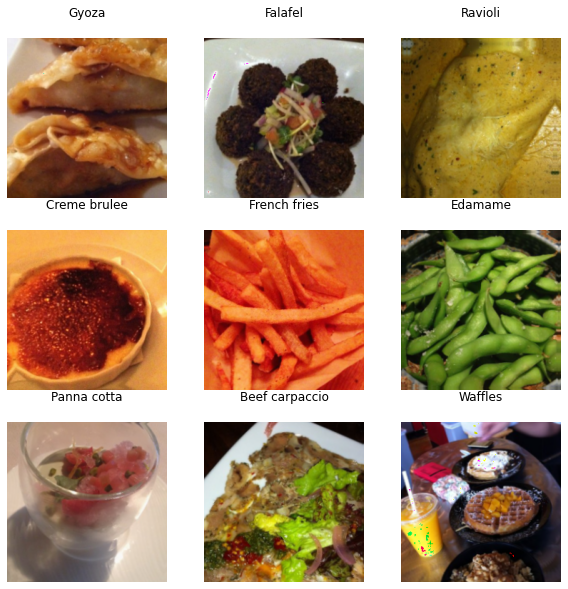

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Testing out different architectures and methods

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.01,
    restore_best_weights=True,
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,                                     
    patience=3,                                   
    min_delta=0.01,
    cooldown=0,                               
    verbose=1
) 

### EfficientNetB3 with fine tuning the top layer

In [14]:
EfficientNetB3=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_width, 3),
    pooling=None,
    classes=101,
)

43950080/43941136 [==============================] - 0s 0us/step


In [15]:
base_out = EfficientNetB3.output
x = tf.keras.layers.GlobalAveragePooling2D()(base_out)
output = layers.Dense(len(class_names), activation='softmax')(x)

model_TL = models.Model(EfficientNetB3.input, output)

In [16]:
len(EfficientNetB3.layers)

384

we will first freeze the base model and train our classification layers on top because we don't want to break our models weights.The pretrained weights we're using are from Imagenet. We have a chance of breaking the pretrained model because our source domain is much different from our target domain. Generaly only the lower level layers (that recognize less complex shapes) will be usefull for us. The further on top the node is, the more specialized it becomes at detecting specific elements in images.

In [17]:
# freezing the base_model:
for layer in EfficientNetB3.layers[:]:
    layer.trainable = False

In [18]:
from tensorflow.keras.optimizers import Adam
model_TL.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer="adam",                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [19]:
history = model_TL.fit(train_ds,
                         validation_data=val_ds,
                         epochs=2,
                         verbose=1)

Epoch 1/2


2022-12-16 20:22:56.122335: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 28s 441ms/step - loss: 4.5543 - sparse_categorical_accuracy: 0.0463 - val_loss: 4.2512 - val_sparse_categorical_accuracy: 0.1450
Epoch 2/2
25/25 [==============================] - 4s 143ms/step - loss: 3.3822 - sparse_categorical_accuracy: 0.4087 - val_loss: 3.7852 - val_sparse_categorical_accuracy: 0.2100


look at the loss curves

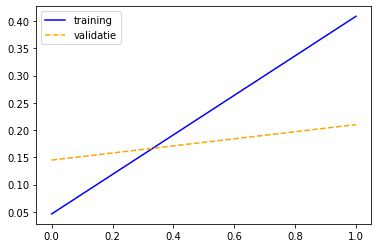

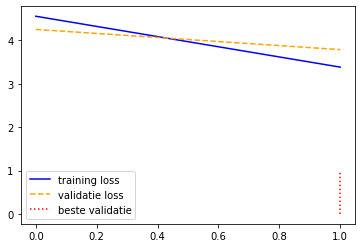

In [20]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training loss', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie loss', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [21]:
loss, categorical_accuracy = model_TL.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

32/32 [==============================] - 5s 141ms/step - loss: 3.7637 - sparse_categorical_accuracy: 0.2070


(3.7636868953704834, 0.2070000022649765)

In [22]:
# unfreezing the base model but keeping the first 190 weights frozen:

for layer in EfficientNetB3.layers[:190]:
    layer.trainable = False
    
for layer in EfficientNetB3.layers[190:]:
    layer.trainable = True

recompile the model with slow LR

In [23]:
model_TL.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer=Adam(
                learning_rate=0.0002,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-08 ),                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [24]:
history = model_TL.fit(train_ds,
                         validation_data=val_ds,
                         epochs=20,
                         callbacks=[early_stopping, plateau],
                         verbose=1)

Epoch 1/20
25/25 [==============================] - 20s 334ms/step - loss: 3.7838 - sparse_categorical_accuracy: 0.2412 - val_loss: 3.6198 - val_sparse_categorical_accuracy: 0.2300
Epoch 2/20
25/25 [==============================] - 6s 241ms/step - loss: 1.9903 - sparse_categorical_accuracy: 0.8500 - val_loss: 3.3750 - val_sparse_categorical_accuracy: 0.2550
Epoch 3/20
25/25 [==============================] - 6s 242ms/step - loss: 1.0604 - sparse_categorical_accuracy: 0.9762 - val_loss: 3.1947 - val_sparse_categorical_accuracy: 0.2950
Epoch 4/20
25/25 [==============================] - 6s 244ms/step - loss: 0.4982 - sparse_categorical_accuracy: 0.9975 - val_loss: 3.0989 - val_sparse_categorical_accuracy: 0.2950
Epoch 5/20
25/25 [==============================] - 6s 246ms/step - loss: 0.2861 - sparse_categorical_accuracy: 0.9975 - val_loss: 3.0292 - val_sparse_categorical_accuracy: 0.2850
Epoch 6/20
25/25 [==============================] - 6s 250ms/step - loss: 0.1589 - sparse_categoric

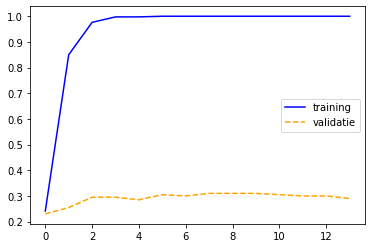

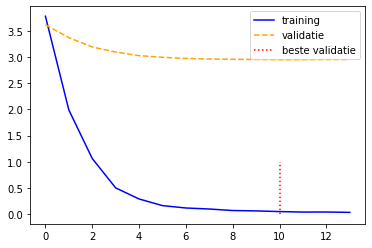

In [25]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [26]:
loss, categorical_accuracy = model_TL.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

32/32 [==============================] - 4s 114ms/step - loss: 3.1993 - sparse_categorical_accuracy: 0.2630


(3.199324131011963, 0.2630000114440918)

In [27]:
model_TL.save_weights('EfficientNetB3_finetuned.h5')

### EfficientNetB3 finetune with a more complex top layer

In [28]:
EfficientNetB3=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_width, 3),
    pooling=None,
    classes=101,
)

base_out = EfficientNetB3.output
x = tf.keras.layers.GlobalAveragePooling2D()(base_out)
x = layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)

model_TL_complex = models.Model(EfficientNetB3.input, output)

# freezing the base_model:
for layer in EfficientNetB3.layers[:]:
    layer.trainable = False

from tensorflow.keras.optimizers import Adam
model_TL_complex.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer="adam",                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model_TL_complex.fit(train_ds,
                         validation_data=val_ds,
                         epochs=4,
                         verbose=1)
# unfreezing the base model but keeping the first 190 weights frozen:

for layer in EfficientNetB3.layers[:190]:
    layer.trainable = False
    
for layer in EfficientNetB3.layers[190:]:
    layer.trainable = True

model_TL_complex.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer=Adam(
                learning_rate=0.0002,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-08 ),                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model_TL_complex.fit(train_ds,
                         validation_data=val_ds,
                         epochs=20,
                         callbacks=[early_stopping, plateau],
                         verbose=1)

Epoch 1/4
25/25 [==============================] - 14s 234ms/step - loss: 5.0701 - sparse_categorical_accuracy: 0.0300 - val_loss: 4.8103 - val_sparse_categorical_accuracy: 0.1050
Epoch 2/4
25/25 [==============================] - 4s 160ms/step - loss: 4.2710 - sparse_categorical_accuracy: 0.1887 - val_loss: 4.4552 - val_sparse_categorical_accuracy: 0.1600
Epoch 3/4
25/25 [==============================] - 4s 157ms/step - loss: 3.5050 - sparse_categorical_accuracy: 0.3550 - val_loss: 4.0535 - val_sparse_categorical_accuracy: 0.2350
Epoch 4/4
25/25 [==============================] - 4s 157ms/step - loss: 2.8753 - sparse_categorical_accuracy: 0.4950 - val_loss: 3.7850 - val_sparse_categorical_accuracy: 0.2750
Epoch 1/20
25/25 [==============================] - 19s 342ms/step - loss: 4.1006 - sparse_categorical_accuracy: 0.2300 - val_loss: 3.8173 - val_sparse_categorical_accuracy: 0.2650
Epoch 2/20
25/25 [==============================] - 7s 266ms/step - loss: 2.7366 - sparse_categorical_

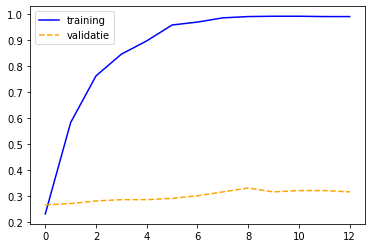

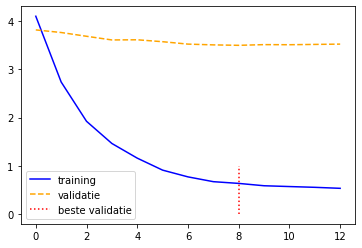

In [29]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [30]:
loss, categorical_accuracy = model_TL_complex.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

32/32 [==============================] - 4s 115ms/step - loss: 3.6424 - sparse_categorical_accuracy: 0.2720


(3.64237642288208, 0.2720000147819519)

In [31]:
model_TL_complex.save_weights('EfficientNetB3_complex_finetuned.h5')

the more complex top layer did not make a big difference

### EfficientNetB3 with different fine tuning approach

instead of keeping the first 190 layers frozen we will try to see what the effect is if we keep the first 380 layers frozen and anly finetine a handfull of convolution layers on top instead of half of the pretrained model

In [32]:
EfficientNetB3=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_width, 3),
    pooling=None,
    classes=101,
)

base_out = EfficientNetB3.output
x = tf.keras.layers.GlobalAveragePooling2D()(base_out)
x = layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)

model_TL_complex_finetune2 = models.Model(EfficientNetB3.input, output)

# freezing the base_model:
for layer in EfficientNetB3.layers[:]:
    layer.trainable = False

from tensorflow.keras.optimizers import Adam
model_TL_complex_finetune2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer="adam",                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model_TL_complex_finetune2.fit(train_ds,
                         validation_data=val_ds,
                         epochs=4,
                         verbose=1)
# unfreezing the base model but keeping the first 380 weights frozen:

for layer in EfficientNetB3.layers[:380]:
    layer.trainable = False
    
for layer in EfficientNetB3.layers[380:]:
    layer.trainable = True

model_TL_complex_finetune2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer=Adam(
                learning_rate=0.0002,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-08 ),                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model_TL_complex_finetune2.fit(train_ds,
                         validation_data=val_ds,
                         epochs=20,
                         callbacks=[early_stopping, plateau],
                         verbose=1)

Epoch 1/4
25/25 [==============================] - 14s 243ms/step - loss: 5.0753 - sparse_categorical_accuracy: 0.0188 - val_loss: 4.8029 - val_sparse_categorical_accuracy: 0.1050
Epoch 2/4
25/25 [==============================] - 4s 156ms/step - loss: 4.2892 - sparse_categorical_accuracy: 0.2100 - val_loss: 4.4132 - val_sparse_categorical_accuracy: 0.2050
Epoch 3/4
25/25 [==============================] - 4s 157ms/step - loss: 3.5443 - sparse_categorical_accuracy: 0.3550 - val_loss: 4.0576 - val_sparse_categorical_accuracy: 0.2300
Epoch 4/4
25/25 [==============================] - 4s 158ms/step - loss: 2.8461 - sparse_categorical_accuracy: 0.4950 - val_loss: 3.7444 - val_sparse_categorical_accuracy: 0.3050
Epoch 1/20
25/25 [==============================] - 14s 247ms/step - loss: 2.6189 - sparse_categorical_accuracy: 0.5850 - val_loss: 3.7088 - val_sparse_categorical_accuracy: 0.3100
Epoch 2/20
25/25 [==============================] - 4s 159ms/step - loss: 2.2280 - sparse_categorical_

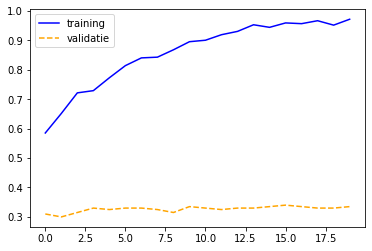

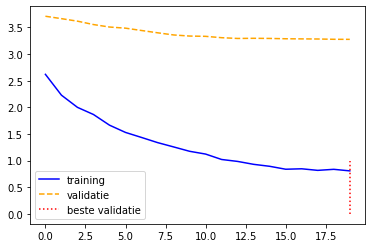

In [33]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [34]:
loss, categorical_accuracy = model_TL_complex_finetune2.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

32/32 [==============================] - 4s 117ms/step - loss: 3.2588 - sparse_categorical_accuracy: 0.3380


(3.25883412361145, 0.33799999952316284)

In [35]:
model_TL_complex_finetune2.save_weights('EfficientNetB3_complex_finetuned2.h5')

this approach yielded the best results untill now

### EfficientNetB3 fully training the model

In [36]:
EfficientNetB3=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_width, 3),
    classes=101,
)

we will train the whole model at once

In [37]:
EfficientNetB3.trainable=True

In [38]:
model_TL = tf.keras.Sequential([
    EfficientNetB3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(101, activation='softmax'),
])

In [39]:
model_TL.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model_TL.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               196736    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 101)               13029     
Total params: 10,993,300
Trainable params: 10,905,997
Non-trainable params: 87,303
_________________________________________________________________


In [40]:
EPOCHS=20

with tf.device('/GPU:0'):
    hist = model_TL.fit(
        train_ds,
        validation_data = val_ds,
        epochs = 20,
        callbacks=[early_stopping, plateau],
    )

Epoch 1/20
25/25 [==============================] - 32s 723ms/step - loss: 4.6415 - sparse_categorical_accuracy: 0.0175 - val_loss: 4.5477 - val_sparse_categorical_accuracy: 0.0450
Epoch 2/20
25/25 [==============================] - 16s 653ms/step - loss: 3.8647 - sparse_categorical_accuracy: 0.1700 - val_loss: 4.4002 - val_sparse_categorical_accuracy: 0.1150
Epoch 3/20
25/25 [==============================] - 16s 639ms/step - loss: 2.8178 - sparse_categorical_accuracy: 0.3800 - val_loss: 4.8937 - val_sparse_categorical_accuracy: 0.0950
Epoch 4/20
25/25 [==============================] - 16s 632ms/step - loss: 1.8425 - sparse_categorical_accuracy: 0.5863 - val_loss: 4.5638 - val_sparse_categorical_accuracy: 0.1850
Epoch 5/20
25/25 [==============================] - 16s 635ms/step - loss: 1.0952 - sparse_categorical_accuracy: 0.7500 - val_loss: 4.7659 - val_sparse_categorical_accuracy: 0.1850

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/20
25

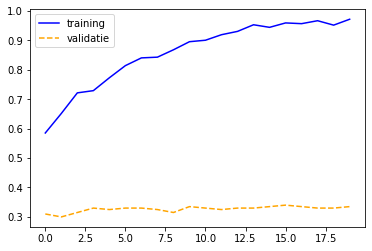

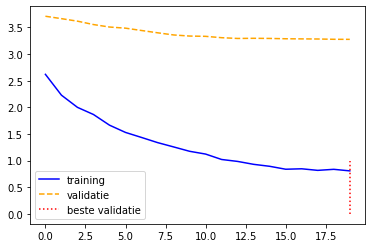

In [41]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [42]:
loss, categorical_accuracy = model_TL.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

32/32 [==============================] - 4s 115ms/step - loss: 4.0439 - sparse_categorical_accuracy: 0.2010


(4.043946266174316, 0.20100000500679016)

In [43]:
model_TL.save_weights('EfficientNetB3_full_train.h5')

this is what we already had expected, by training the whole model at once we are actually not using it on it's full potential. Because our source domain is different from our destination domain we are ruining the pretrained weights. We can train our model longer and might get better results but is not our purpose. We want to use a pretrained model so our training time is shorter.

until now we only used the HDF5 files which provided us with 1000 training images. From the experiments above we learned that the best method was **EfficientNetB3 with different fine tuning approach**. We will now use that same approach but on a 80% of the whole dataset and use the last 20% as test images

We won't use the HDF5 files because the images available in them are cropped instead of squeezed, this makes the food very hard to recognize (even for humans like me). That's why we decided to use the original images and resize them ourselves

### loading our data from directory


In [ ]:
dataset_root_path=Path("/project_ghent/raman/project/food41")

In [ ]:
data_dir=dataset_root_path/"train"
test_dir=dataset_root_path/"test"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=47,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=47,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=47,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75750 files belonging to 101 classes.
Using 60600 files for training.


2022-12-16 20:11:16.805643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 20:11:19.554186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10041 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


Found 75750 files belonging to 101 classes.
Using 15150 files for validation.
Found 25250 files belonging to 101 classes.


In [ ]:
def prepare_dataset(ds, batch_size=32, b_shuffle=True,augment=True):
    # transform input data into tf.data
    
    ds = ds.map(map_func = preprocessing ,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    # normally you only need to shuffle the training data
    if b_shuffle == True:
        ds = ds.shuffle(255)
    # normally you only need to shuffle the training data
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # ds = ds.batch(batch_size)
    # ds = ds.cache()
    ds = ds.prefetch(buffer_size = 255)
    return ds



def preprocessing(image, label):
    image = resize(image)
    return image, label


train_ds = prepare_dataset(train_ds,augment=True)
val_ds = prepare_dataset(val_ds, b_shuffle = False,augment=False)
test_ds = prepare_dataset(test_ds, b_shuffle = False,augment=False)

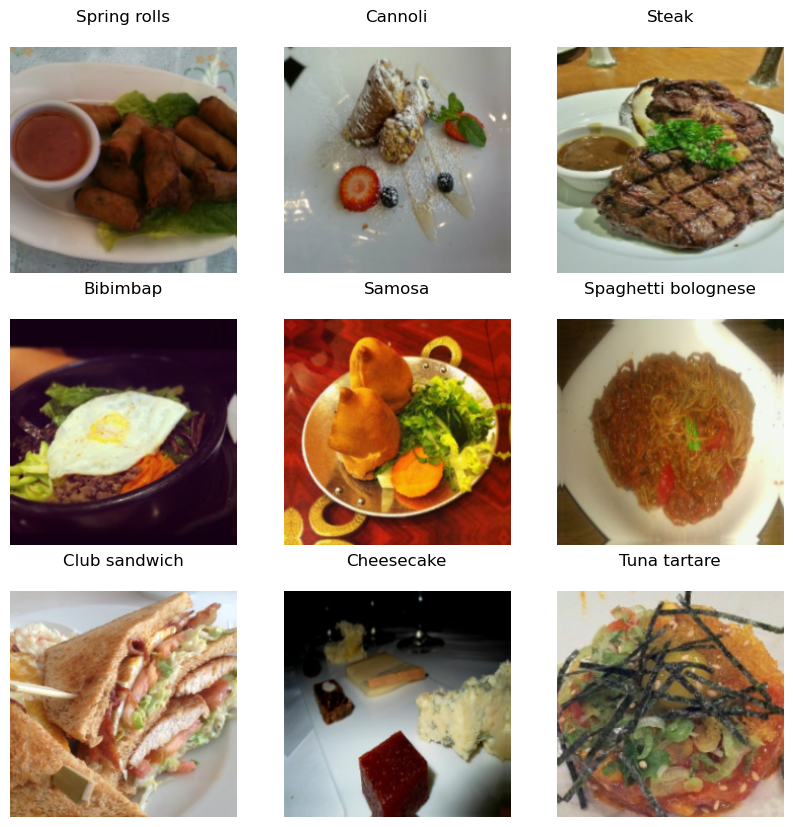

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(9):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

as we can see here, the resize strategy was squeeze instead of crop, we can still recognise the different food classes

### EfficientNetB3 different fine-tuning approach and using full dataset

In [ ]:
EfficientNetB3=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_width, 3),
    pooling=None,
    classes=101,
)

base_out = EfficientNetB3.output
x = tf.keras.layers.GlobalAveragePooling2D()(base_out)
x = layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)

model_TL_complex_finetune_full = models.Model(EfficientNetB3.input, output)

# freezing the base_model:
for layer in EfficientNetB3.layers[:]:
    layer.trainable = False

from tensorflow.keras.optimizers import Adam
model_TL_complex_finetune_full.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer="adam",                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model_TL_complex_finetune_full.fit(train_ds,
                         validation_data=val_ds,
                         epochs=4,
                         verbose=1)
# unfreezing the base model but keeping the first 380 weights frozen:

for layer in EfficientNetB3.layers[:380]:
    layer.trainable = False
    
for layer in EfficientNetB3.layers[380:]:
    layer.trainable = True

model_TL_complex_finetune_full.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer=Adam(
                learning_rate=0.0002,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-08 ),                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model_TL_complex_finetune_full.fit(train_ds,
                         validation_data=val_ds,
                         epochs=20,
                         callbacks=[early_stopping, plateau],
                         verbose=1)

Epoch 1/4


2022-12-16 20:14:57.381678: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


1894/1894 [==============================] - 478s 238ms/step - loss: 2.8847 - sparse_categorical_accuracy: 0.3930 - val_loss: 2.0496 - val_sparse_categorical_accuracy: 0.5786
Epoch 2/4
1894/1894 [==============================] - 457s 236ms/step - loss: 2.4611 - sparse_categorical_accuracy: 0.4744 - val_loss: 1.9922 - val_sparse_categorical_accuracy: 0.5861
Epoch 3/4
1894/1894 [==============================] - 456s 235ms/step - loss: 2.4193 - sparse_categorical_accuracy: 0.4884 - val_loss: 1.9879 - val_sparse_categorical_accuracy: 0.5896
Epoch 4/4
1894/1894 [==============================] - 457s 236ms/step - loss: 2.3987 - sparse_categorical_accuracy: 0.4913 - val_loss: 1.9858 - val_sparse_categorical_accuracy: 0.5929
Epoch 1/20
1894/1894 [==============================] - 476s 239ms/step - loss: 2.1633 - sparse_categorical_accuracy: 0.5386 - val_loss: 1.7121 - val_sparse_categorical_accuracy: 0.6389 - lr: 2.0000e-04
Epoch 2/20
1894/1894 [==============================] - 458s 236ms/

2022-12-16 22:25:23.872810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 227 of 255
2022-12-16 22:25:25.034836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1894/1894 [==============================] - 463s 238ms/step - loss: 1.2544 - sparse_categorical_accuracy: 0.7088 - val_loss: 1.3255 - val_sparse_categorical_accuracy: 0.7003 - lr: 4.0000e-05
Epoch 15/20
1894/1894 [==============================] - 459s 237ms/step - loss: 1.2489 - sparse_categorical_accuracy: 0.7089 - val_loss: 1.3211 - val_sparse_categorical_accuracy: 0.7014 - lr: 4.0000e-05
Epoch 16/20
1894/1894 [==============================] - ETA: 0s - loss: 1.2286 - sparse_categorical_accuracy: 0.7132
Epoch 16: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
1894/1894 [==============================] - 466s 241ms/step - loss: 1.2286 - sparse_categorical_accuracy: 0.7132 - val_loss: 1.3185 - val_sparse_categorical_accuracy: 0.7024 - lr: 4.0000e-05
Epoch 17/20
1894/1894 [==============================] - 462s 238ms/step - loss: 1.2029 - sparse_categorical_accuracy: 0.7197 - val_loss: 1.3118 - val_sparse_categorical_accuracy: 0.7032 - lr: 8.0000e-06
Epoch 18/20
1

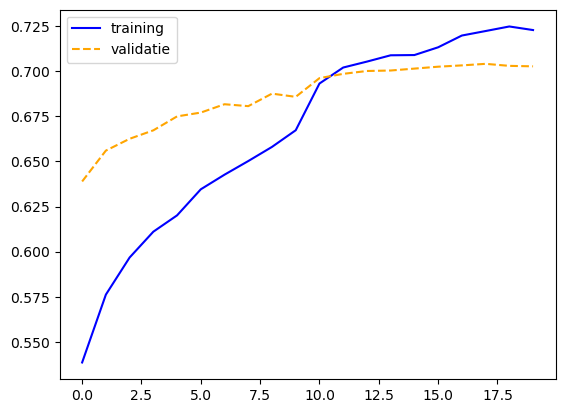

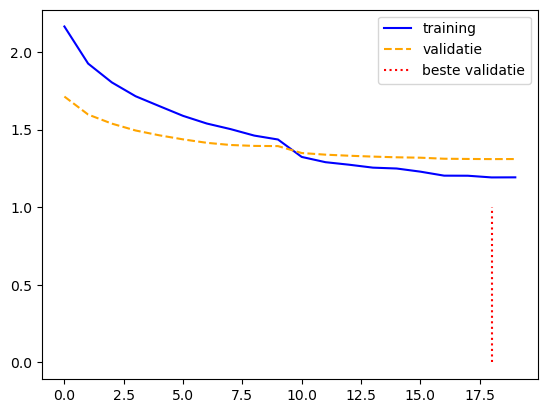

In [ ]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [4]:
loss, categorical_accuracy = model_TL_complex_finetune_full.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

790/790 [==============================] - 62s 78ms/step - loss: 1.0837 - sparse_categorical_accuracy: 0.7479
(1.0836948156356812, 0.7478811740875244)


In [ ]:
model_TL_complex_finetune_full.save_weights('EfficientNetB3_complex_finetuned_full.h5')

## using our model to make recommendations

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from fastai.imports import *
from fastai.vision.all import *
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import *


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
batch_size = 32
img_height = 224
img_width =224

In [4]:
EfficientNetB3=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_width, 3),
    pooling=None,
    classes=101,
)

base_out = EfficientNetB3.output
x = tf.keras.layers.GlobalAveragePooling2D()(base_out)
x = layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(101, activation='softmax')(x)

model_TL_complex_finetune_full = tf.keras.models.Model(EfficientNetB3.input, output)

In [5]:
model_TL_complex_finetune_full.load_weights("./EfficientNetB3_complex_finetuned_full.h5")

we have to remember that our model has a rescaling layer included, the only preprocssing we have to do is resize our images

In [51]:
img_folder = "D:/industrieel_ingenieur/4de_jaar/ML/labo/lab1/tripadvisor_dataset/tripadvisor_images_small"

def create_dataset(img_folder, n=None):
    # n = amount of images
    image_files=os.listdir(os.path.join(img_folder))
    if n==None:
        n=len(image_files)
    images = np.zeros((n, img_height, img_width, 3))
    for i,file in enumerate(image_files[90:90+n]):
        img=PILImage.create(os.path.join(img_folder,file))
        img_resized=img.resize((img_width,img_height))
        images[i]=img_resized
    return images

images = create_dataset(img_folder,10)

In [52]:
preds=model_TL_complex_finetune_full.predict(images)


1/1 [==============================] - 1s 1s/step


In [53]:
class_names=[]
fo = open("./labels_food101.txt")
for line in fo:
    class_names.append(line)
fo.close()

In [54]:
preds=np.argmax(preds,axis=1)

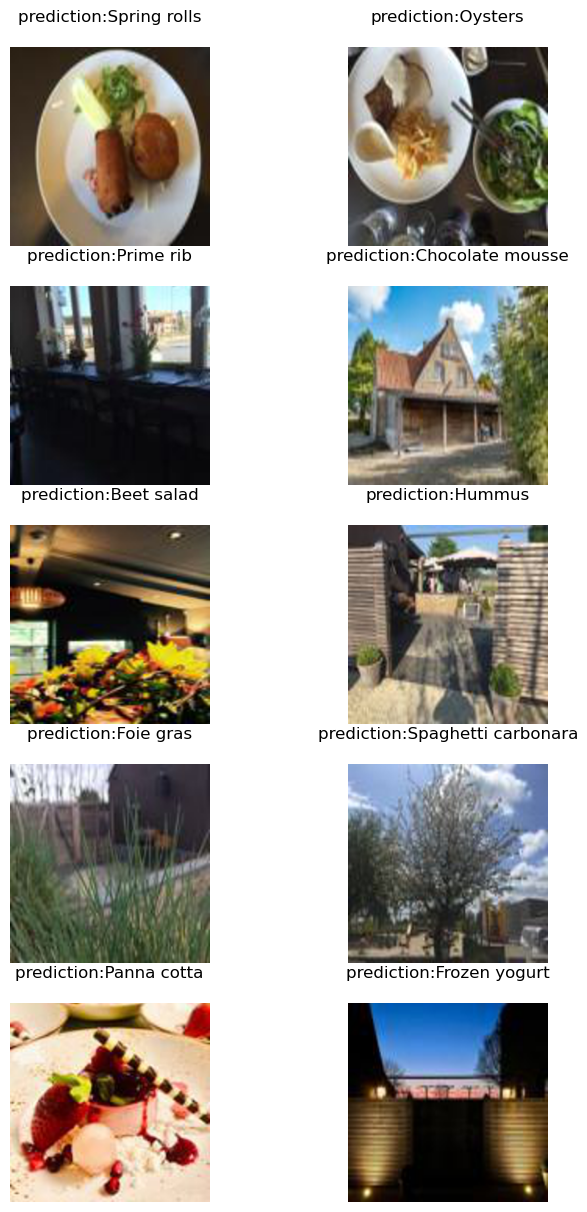

In [55]:
plt.figure(figsize=(8, 15))

for i,(img, pred) in enumerate(zip(images,preds)):
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"prediction:{class_names[pred]}")
    plt.axis("off")